<a href="https://colab.research.google.com/github/boskya/aai521-real-tile-asl-recognition/blob/main/asl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Set up project directory in Drive
project_dir = '/content/drive/MyDrive/ASL_Project'
!mkdir -p {project_dir}/data
!mkdir -p {project_dir}/models
!mkdir -p {project_dir}/checkpoints

%cd {project_dir}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ASL_Project


In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Check GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Check if dataset already exists
data_path = f'{project_dir}/data/asl_alphabet_train'

if not os.path.exists(data_path):
    print("Downloading dataset...")
    !curl -L -o {project_dir}/asl-alphabet.zip \
      https://www.kaggle.com/api/v1/datasets/download/grassknoted/asl-alphabet

    print("Extracting dataset...")
    !unzip -q {project_dir}/asl-alphabet.zip -d {project_dir}/data/

    print("Cleaning up zip file...")
    !rm {project_dir}/asl-alphabet.zip

    print("Dataset ready!")
else:
    print("Dataset already exists in Drive. Skipping download.")

# Set data directory
data_dir = f'{project_dir}/data/asl_alphabet_train/asl_alphabet_train'

Dataset already exists in Drive. Skipping download.


data/asl_alphabet_train
data/asl_alphabet_train/asl_alphabet_train
Number of classes: 29
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

Images per class:
A: 3000 images
B: 3000 images
C: 3000 images
D: 3000 images
E: 3000 images
F: 3000 images
G: 3000 images
H: 3000 images
I: 3000 images
J: 3000 images
K: 3000 images
L: 3000 images
M: 3000 images
N: 3000 images
O: 3080 images
P: 3000 images
Q: 3000 images
R: 3000 images
S: 3000 images
T: 3000 images
U: 3000 images
V: 3000 images
W: 3000 images
X: 3000 images
Y: 3000 images
Z: 3032 images
del: 3000 images
nothing: 3000 images
space: 3000 images


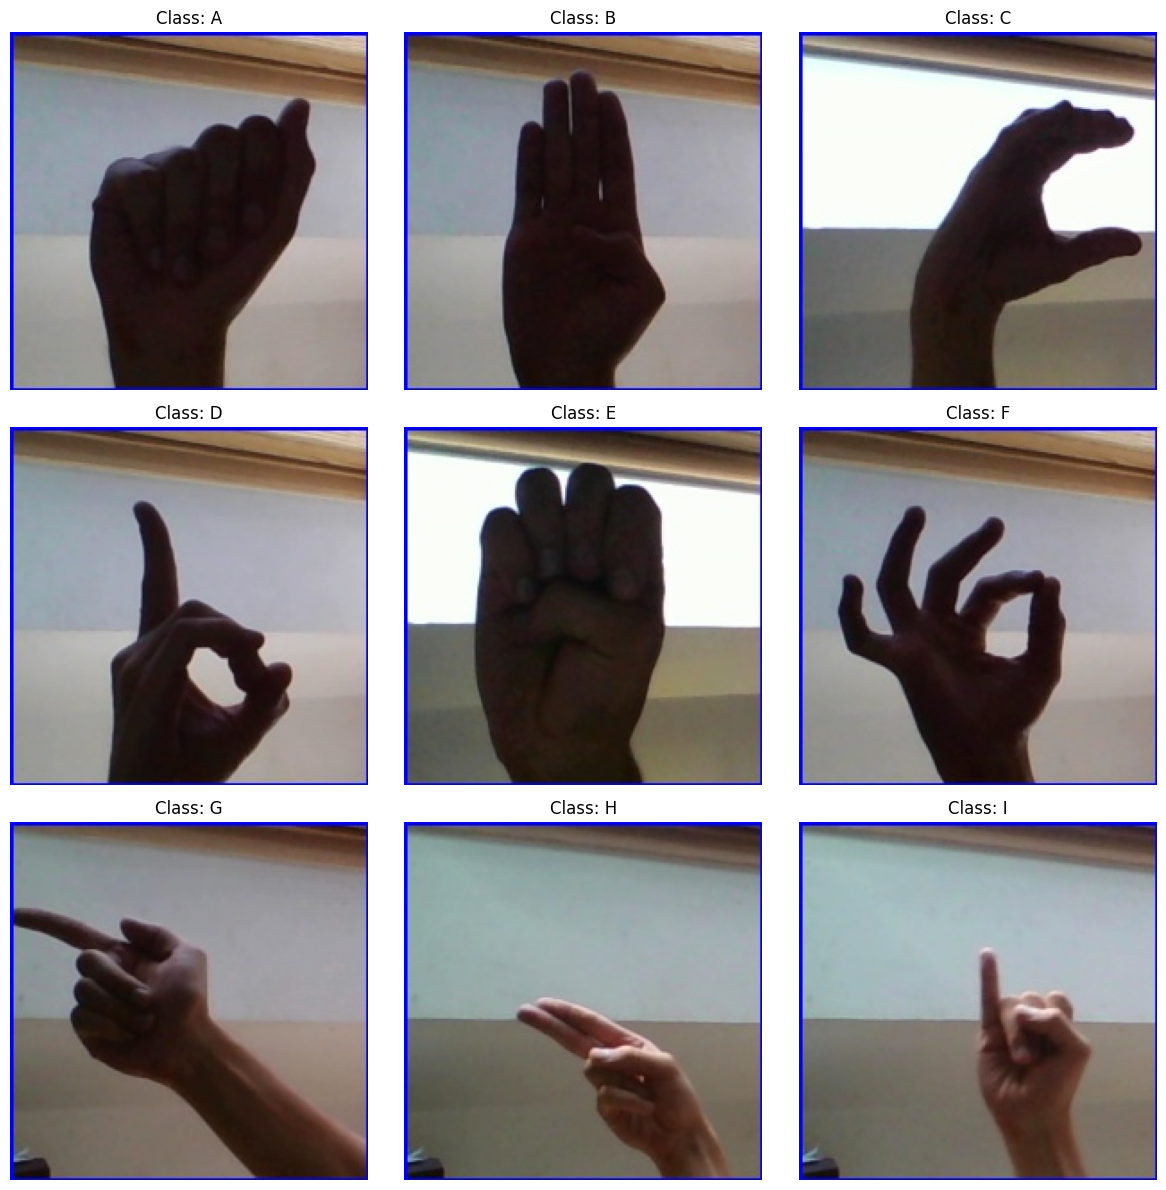

In [5]:
# Find the correct path (Kaggle datasets can have nested folders)
!find data/ -type d -name "asl_alphabet_train"

# Set the correct path (adjust after running above command)
data_dir = 'data/asl_alphabet_train/asl_alphabet_train'

# Get classes
classes = sorted(os.listdir(data_dir))
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

# Count images per class
print("\nImages per class:")
for cls in classes:
    count = len(os.listdir(os.path.join(data_dir, cls)))
    print(f"{cls}: {count} images")

# Visualize samples from different classes
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < len(classes):
        cls = classes[i]
        cls_dir = os.path.join(data_dir, cls)
        img_name = os.listdir(cls_dir)[0]
        img_path = os.path.join(cls_dir, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(f"Class: {cls}")
        ax.axis('off')
plt.tight_layout()
plt.show()

# Model training

In [6]:
# Copy dataset from Drive to local Colab storage
local_data_dir = '/content/asl_data'
local_data_dir_train = '/content/asl_data/asl_alphabet_train'

In [7]:
# Copy dataset from Drive to local Colab storage
local_data_dir = '/content/asl_data'

print("Copying dataset to local Colab storage for faster training...")
!mkdir -p {local_data_dir}
!cp -r {data_dir} {local_data_dir}/

print("Copy complete! Verifying...")
!ls {local_data_dir}/asl_alphabet_train/ | head -10

Copying dataset to local Colab storage for faster training...
Copy complete! Verifying...
A
B
C
D
del
E
F
G
H
I


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

print("="*60)
print("REBUILDING MODEL WITH CORRECT CONFIGURATION")
print("="*60)

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_CLASSES = 29
EPOCHS = 15
actual_class_dir=local_data_dir_train

# ============================================================
# DATA GENERATORS WITH CORRECT PREPROCESSING
# ============================================================

print("\nSetting up data generators...")

# Use EfficientNet preprocessing in the generator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # CRITICAL: EfficientNet preprocessing
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    actual_class_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    actual_class_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"✓ Training samples: {train_generator.samples}")
print(f"✓ Validation samples: {val_generator.samples}")

# Verify labels are correct
x_batch, y_batch = next(train_generator)
print(f"\nLabel verification:")
print(f"  Shape: {y_batch.shape}")
print(f"  Sum: {np.sum(y_batch[0])}")
if y_batch.shape[1] == NUM_CLASSES and abs(np.sum(y_batch[0]) - 1.0) < 0.01:
    print("✓ Labels are correct one-hot encoding")
else:
    print("✗ ERROR: Labels are incorrect!")

REBUILDING MODEL WITH CORRECT CONFIGURATION

Setting up data generators...
Found 69690 images belonging to 29 classes.
Found 17422 images belonging to 29 classes.
✓ Training samples: 69690
✓ Validation samples: 17422

Label verification:
  Shape: (128, 29)
  Sum: 1.0
✓ Labels are correct one-hot encoding


In [9]:
import glob
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Get number of classes
classes = sorted(os.listdir(data_dir))
NUM_CLASSES = len(classes)
IMG_SIZE = 224

# Check for existing checkpoints
checkpoint_files = sorted(glob.glob(f'{project_dir}/checkpoints/*.h5') +
                          glob.glob(f'{project_dir}/checkpoints/*.keras'))

if checkpoint_files:
    print("Found existing checkpoints:")
    for i, cp in enumerate(checkpoint_files[-5:]):  # Show last 5
        print(f"{i}: {os.path.basename(cp)}")

    # Load latest checkpoint
    latest_checkpoint = checkpoint_files[-1]
    print(f"\nLoading: {latest_checkpoint}")
    model = tf.keras.models.load_model(latest_checkpoint)

    # Continue training from this checkpoint
    try:
        # Extract epoch number from filename (format: asl_checkpoint_XX_0.XXXX.h5)
        epoch_part = os.path.basename(latest_checkpoint).split('_')[2]
        initial_epoch = int(epoch_part)
        print(f"Resuming from epoch {initial_epoch}")
    except:
        print("Could not parse epoch number, starting from epoch 0")
        initial_epoch = 0

else:
  print("\nNo checkpoints found. Building fresh model...")
  initial_epoch = 0

  # Load base model
  base_model = EfficientNetB0(
      weights='imagenet',
      input_shape=(IMG_SIZE, IMG_SIZE, 3),
      include_top=False
  )

  # Freeze base model for initial training
  base_model.trainable = False
  print(f"  Base model layers: {len(base_model.layers)} (all frozen)")

  # Build SIMPLE model WITHOUT data augmentation layer
  # (Data augmentation caused the previous failure)
  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ], name='ASL')

  # Compile
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  print("✓ Model built successfully")

# Display model summary
print("\nModel Summary:")
model.summary()
print(f"\nReady to train from epoch {initial_epoch}")

Found existing checkpoints:
0: asl_checkpoint_08_0.9146.keras
1: asl_checkpoint_09_0.9111.keras
2: asl_checkpoint_10_0.9214.keras
3: asl_checkpoint_11_0.9168.keras
4: asl_checkpoint_12_0.9213.keras

Loading: /content/drive/MyDrive/ASL_Project/checkpoints/asl_checkpoint_12_0.9213.keras
Resuming from epoch 12

Model Summary:


Model: "ASL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,055,740 (19.29 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 670,780 (2.56 MB)


Ready to train from epoch 12


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks with checkpointing
checkpoint_path = f'{project_dir}/checkpoints/asl_checkpoint_{{epoch:02d}}_{{val_accuracy:.4f}}.keras'

callbacks = [
    # Save best model
    ModelCheckpoint(
        f'{project_dir}/models/asl_model_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    # Save checkpoint every epoch
    ModelCheckpoint(
        checkpoint_path,
        save_freq='epoch',
        verbose=1
    ),
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n" + "="*60)
print("Starting training with correct EfficientNet preprocessing")
print("="*60)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save(f'{project_dir}/models/asl_model_final.keras')
print("\n✓ Training complete! Model saved to Drive.")


Starting training with correct EfficientNet preprocessing


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 13/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9944 - loss: 0.0167
Epoch 13: val_accuracy improved from -inf to 0.92274, saving model to /content/drive/MyDrive/ASL_Project/models/asl_model_best.keras

Epoch 13: saving model to /content/drive/MyDrive/ASL_Project/checkpoints/asl_checkpoint_13_0.9227.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 197s 306ms/step - accuracy: 0.9944 - loss: 0.0167 - val_accuracy: 0.9227 - val_loss: 0.2629 - learning_rate: 5.0000e-04
Epoch 14/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9943 - loss: 0.0183
Epoch 14: val_accuracy did not improve from 0.92274

Epoch 14: saving model to /content/drive/MyDrive/ASL_Project/checkpoints/asl_checkpoint_14_0.9223.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 129s 237ms/step - accuracy: 0.9943 - loss: 0.0183 - val_accuracy: 0.9223 - val_loss: 0.3080 - learning_rate: 5.0000e-04
Epoch 15/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9942 - loss: 0.0175
Epoch 15: val_accuracy did not improve f

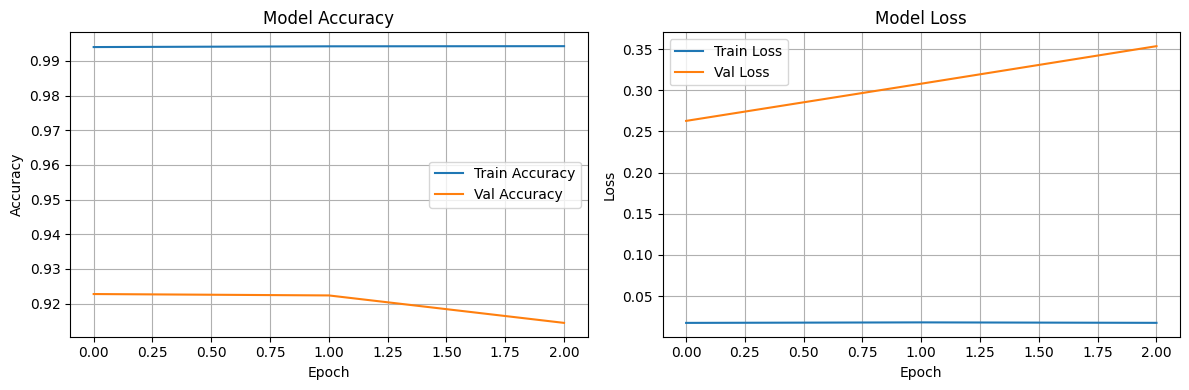


Final Training Accuracy: 0.9943
Final Validation Accuracy: 0.9144


In [11]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [13]:
!pip install mediapipe opencv-python

In [16]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from collections import deque

data_dir_local = local_data_dir_train

# Load your best model
print("Loading trained model...")
model = tf.keras.models.load_model(f'{project_dir}/models/asl_model_best.keras')


# Get class labels
classes = sorted(os.listdir(local_data_dir_train))
print(f"\n✓ Model loaded with {len(classes)} classes")
print(f"Classes: {classes}")

Loading trained model...

✓ Model loaded with 29 classes
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [17]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

print("✓ MediaPipe Hands initialized")

✓ MediaPipe Hands initialized


In [18]:
def preprocess_hand_region(hand_region):
    """
    Preprocess hand region for model prediction
    """
    # Resize to model input size
    img_resized = cv2.resize(hand_region, (224, 224))

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Add batch dimension
    img_array = np.expand_dims(img_rgb, axis=0)

    # Apply EfficientNet preprocessing
    img_preprocessed = tf.keras.applications.efficientnet.preprocess_input(img_array)

    return img_preprocessed

def get_hand_bbox(hand_landmarks, frame_width, frame_height, padding=30):
    """
    Get bounding box around hand landmarks with padding
    """
    # Get all landmark coordinates
    x_coords = [landmark.x * frame_width for landmark in hand_landmarks.landmark]
    y_coords = [landmark.y * frame_height for landmark in hand_landmarks.landmark]

    # Calculate bounding box with padding
    x_min = max(0, int(min(x_coords)) - padding)
    x_max = min(frame_width, int(max(x_coords)) + padding)
    y_min = max(0, int(min(y_coords)) - padding)
    y_max = min(frame_height, int(max(y_coords)) + padding)

    return x_min, y_min, x_max, y_max

print("✓ Preprocessing functions ready")

✓ Preprocessing functions ready


In [19]:
class TemporalSmoother:
    """
    Smooth predictions over time using majority voting
    """
    def __init__(self, window_size=10):
        self.window_size = window_size
        self.predictions = deque(maxlen=window_size)

    def add_prediction(self, prediction):
        self.predictions.append(prediction)

    def get_smoothed_prediction(self):
        if len(self.predictions) == 0:
            return None

        from collections import Counter
        counts = Counter(self.predictions)
        return counts.most_common(1)[0][0]

    def reset(self):
        self.predictions.clear()

smoother = TemporalSmoother(window_size=10)
print("✓ Temporal smoother initialized")

✓ Temporal smoother initialized


TEST ON UPLOADED IMAGE
Upload an image of an ASL sign...


Saving B_test.jpg to B_test.jpg


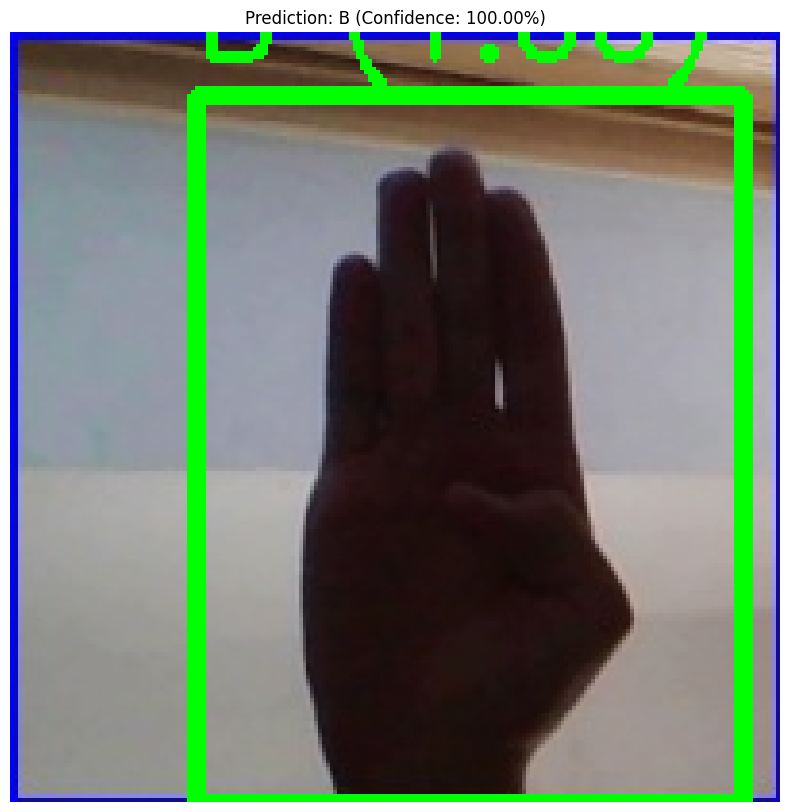


✓ Prediction: B
✓ Confidence: 100.00%

Top 5 predictions:
  B: 100.00%
  U: 0.00%
  E: 0.00%
  H: 0.00%
  I: 0.00%


In [27]:
from google.colab import files
from IPython.display import Image, display
import matplotlib.pyplot as plt

def test_on_uploaded_image():
    """
    Test model on uploaded image (Colab-friendly)
    """
    print("Upload an image of an ASL sign...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Read image
        img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect hands
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Get bounding box
                h, w = img.shape[:2]
                x_min, y_min, x_max, y_max = get_hand_bbox(hand_landmarks, w, h, padding=40)

                # Extract and preprocess
                hand_region = img[y_min:y_max, x_min:x_max]
                processed = preprocess_hand_region(hand_region)

                # Predict
                prediction = model.predict(processed, verbose=0)
                predicted_idx = np.argmax(prediction)
                confidence = np.max(prediction)

                predicted_class = classes[predicted_idx]

                # Draw on image
                cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
                cv2.putText(img_rgb, f"{predicted_class} ({confidence:.2f})",
                           (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX,
                           1, (0, 255, 0), 2)

                # Display
                plt.figure(figsize=(10, 10))
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.title(f"Prediction: {predicted_class} (Confidence: {confidence:.2%})")
                plt.show()

                print(f"\n✓ Prediction: {predicted_class}")
                print(f"✓ Confidence: {confidence:.2%}")

                # Show top 5 predictions
                top_5_idx = np.argsort(prediction[0])[-5:][::-1]
                print("\nTop 5 predictions:")
                for idx in top_5_idx:
                    print(f"  {classes[idx]}: {prediction[0][idx]:.2%}")
        else:
            print("✗ No hand detected in image")
            plt.figure(figsize=(10, 10))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title("No hand detected")
            plt.show()

# Test on uploaded images
print("="*60)
print("TEST ON UPLOADED IMAGE")
print("="*60)
test_on_uploaded_image()

In [31]:
# ============================================================
# REAL-TIME WEBCAM INFERENCE IN GOOGLE COLAB
# ============================================================

from IPython.display import display, Javascript, Image as IPImage
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

def webcam_inference():
    """
    Real-time webcam inference in Colab
    """
    print("="*60)
    print("WEBCAM ASL RECOGNITION")
    print("="*60)
    print("Instructions:")
    print("- Allow camera access when prompted")
    print("- Show ASL signs to the camera")
    print("- Predictions update in real-time")
    print("- Run the cell again to capture another frame")
    print("="*60)

    # JavaScript to access webcam
    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';

            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Let user see themselves
            await new Promise((resolve) => setTimeout(resolve, 2000));

            // Capture frame
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            const img = canvas.toDataURL('image/jpeg', 0.8);

            // Stop stream
            stream.getVideoTracks()[0].stop();
            div.remove();

            return img;
        }
    ''')

    display(js)

    # Capture image from webcam
    data = eval_js('takePhoto()')

    # Decode image
    binary = b64decode(data.split(',')[1])
    img = Image.open(BytesIO(binary))
    img_array = np.array(img)

    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

    # Process with MediaPipe
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw landmarks
            mp_drawing.draw_landmarks(
                img_rgb,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
            )

            # Get bounding box
            h, w = img_bgr.shape[:2]
            x_min, y_min, x_max, y_max = get_hand_bbox(hand_landmarks, w, h, padding=50)

            # Draw bbox
            cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

            # Extract hand region
            hand_region = img_bgr[y_min:y_max, x_min:x_max]

            if hand_region.size > 0:
                # Preprocess
                processed = preprocess_hand_region(hand_region)

                # Predict
                prediction = model.predict(processed, verbose=0)
                predicted_idx = np.argmax(prediction)
                confidence = np.max(prediction)
                predicted_class = classes[predicted_idx]

                # Add prediction to temporal smoother
                if confidence > 0.7:
                    smoother.add_prediction(predicted_class)
                smoothed_prediction = smoother.get_smoothed_prediction()

                # Add text to image
                cv2.putText(img_rgb, f"Raw: {predicted_class} ({confidence:.1%})",
                           (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                if smoothed_prediction:
                    cv2.putText(img_rgb, f"Smoothed: {smoothed_prediction}",
                               (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

                # Display result
                fig, axes = plt.subplots(1, 2, figsize=(16, 8))

                axes[0].imshow(img_rgb)
                axes[0].set_title(f"Prediction: {predicted_class} ({confidence:.1%})",
                                 fontsize=14, fontweight='bold')
                axes[0].axis('off')

                axes[1].imshow(cv2.cvtColor(hand_region, cv2.COLOR_BGR2RGB))
                axes[1].set_title("Extracted Hand Region", fontsize=14)
                axes[1].axis('off')

                plt.tight_layout()
                plt.show()

                # Print results
                print(f"\n{'='*60}")
                print(f"RAW PREDICTION: {predicted_class}")
                print(f"CONFIDENCE: {confidence:.2%}")
                if smoothed_prediction:
                    print(f"SMOOTHED: {smoothed_prediction}")
                print(f"{'='*60}")

                # Top 5
                top_5_idx = np.argsort(prediction[0])[-5:][::-1]
                print("\nTop 5 predictions:")
                for rank, idx in enumerate(top_5_idx, 1):
                    bar = "█" * int(prediction[0][idx] * 50)
                    print(f"  {rank}. {classes[idx]:8s} {prediction[0][idx]:6.2%} {bar}")
    else:
        print("✗ No hand detected")
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.title("No hand detected", fontsize=16, color='red')
        plt.axis('off')
        plt.show()

print("✓ Webcam inference function ready")
print("\nTo capture and predict from webcam, run:")
print("  webcam_inference()")

✓ Webcam inference function ready

To capture and predict from webcam, run:
  webcam_inference()


WEBCAM ASL RECOGNITION
Instructions:
- Allow camera access when prompted
- Show ASL signs to the camera
- Predictions update in real-time
- Run the cell again to capture another frame


<IPython.core.display.Javascript object>

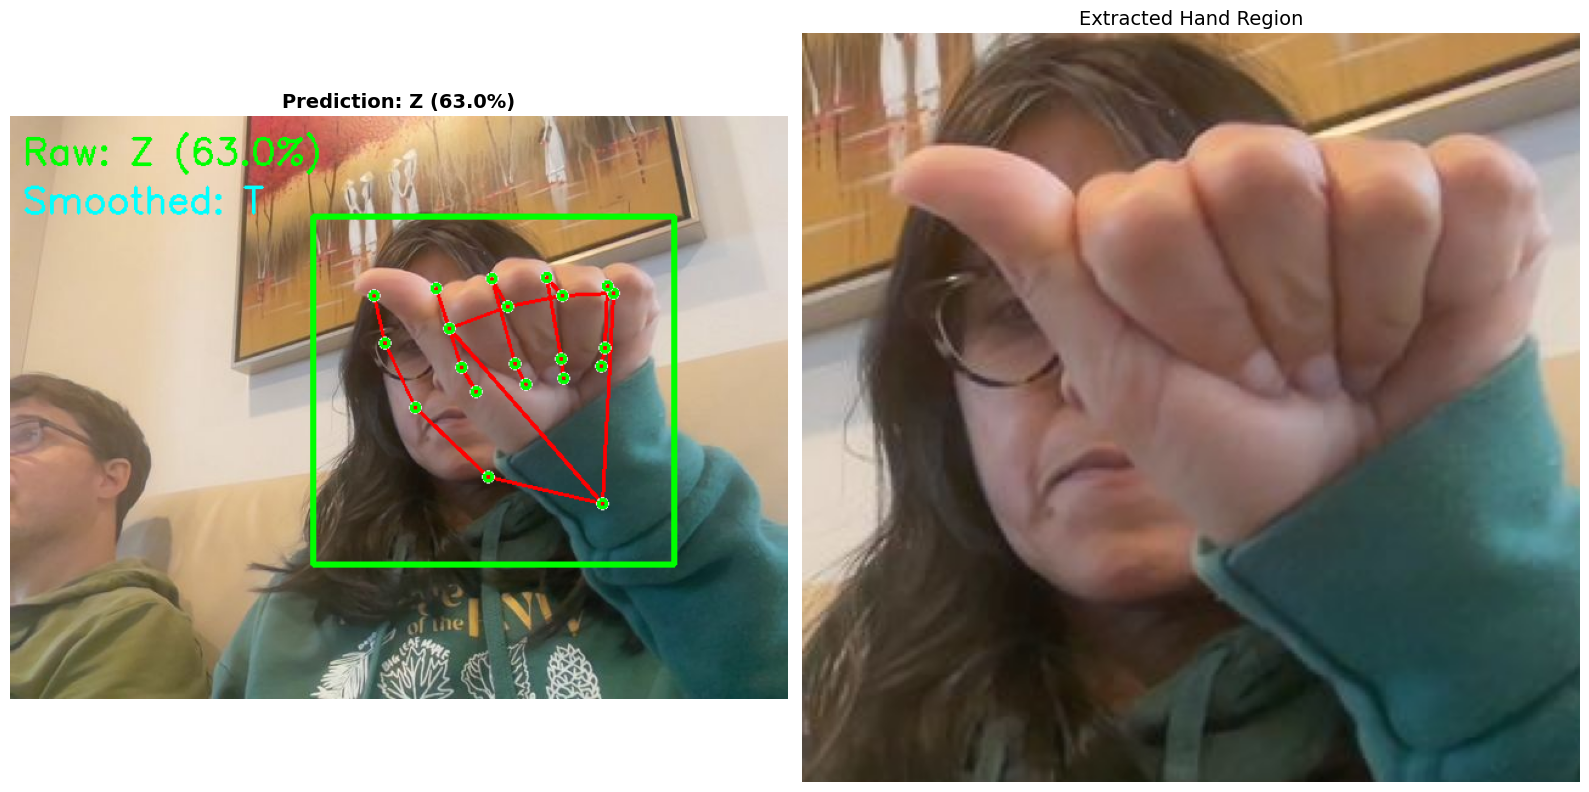


RAW PREDICTION: Z
CONFIDENCE: 62.96%
SMOOTHED: T

Top 5 predictions:
  1. Z        62.96% ███████████████████████████████
  2. Y        15.91% ███████
  3. X        13.05% ██████
  4. H         4.21% ██
  5. T         1.67% 


In [35]:
 webcam_inference()

In [55]:
# ============================================================
# IMPROVED WEBCAM INFERENCE WITH BETTER PREPROCESSING
# ============================================================

def preprocess_hand_region_v2(hand_region):
    """
    Improved preprocessing with background removal and normalization
    """
    # Resize
    img_resized = cv2.resize(hand_region, (224, 224))

    # Convert to RGB
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Optional: Apply histogram equalization for better lighting
    img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    # Add batch dimension
    img_array = np.expand_dims(img_rgb, axis=0)

    # EfficientNet preprocessing
    img_preprocessed = preprocess_input(img_array)

    return img_preprocessed

def get_hand_bbox_tight(hand_landmarks, frame_width, frame_height, padding=20):
    """
    Tighter bounding box to exclude face/background
    """
    x_coords = [landmark.x * frame_width for landmark in hand_landmarks.landmark]
    y_coords = [landmark.y * frame_height for landmark in hand_landmarks.landmark]

    # Use smaller padding to avoid capturing background
    x_min = max(0, int(min(x_coords)) - padding)
    x_max = min(frame_width, int(max(x_coords)) + padding)
    y_min = max(0, int(min(y_coords)) - padding)
    y_max = min(frame_height, int(max(y_coords)) + padding)

    # Make it square (like training data)
    width = x_max - x_min
    height = y_max - y_min
    size = max(width, height)

    # Center the square
    x_center = (x_min + x_max) // 2
    y_center = (y_min + y_max) // 2

    x_min = max(0, x_center - size // 2)
    x_max = min(frame_width, x_center + size // 2)
    y_min = max(0, y_center - size // 2)
    y_max = min(frame_height, y_center + size // 2)

    return x_min, y_min, x_max, y_max

# Update the webcam function to use improved preprocessing
def webcam_inference_v2():
    """
    Improved webcam inference with better preprocessing
    """
    print("="*60)
    print("IMPROVED WEBCAM ASL RECOGNITION")
    print("="*60)
    print("Tips for better recognition:")
    print("- Use a plain background if possible")
    print("- Good lighting (face the light)")
    print("- Hold hand at arm's length from camera")
    print("- Keep hand fully in frame")
    print("="*60)

    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';

            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            await new Promise((resolve) => setTimeout(resolve, 2000));

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            const img = canvas.toDataURL('image/jpeg', 0.8);

            stream.getVideoTracks()[0].stop();
            div.remove();

            return img;
        }
    ''')

    display(js)
    data = eval_js('takePhoto()')

    binary = b64decode(data.split(',')[1])
    img = Image.open(BytesIO(binary))
    img_array = np.array(img)
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw landmarks
            mp_drawing.draw_landmarks(
                img_rgb,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
            )

            # Get TIGHT bounding box
            h, w = img_bgr.shape[:2]
            x_min, y_min, x_max, y_max = get_hand_bbox_tight(hand_landmarks, w, h, padding=30)

            cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

            hand_region = img_bgr[y_min:y_max, x_min:x_max]

            if hand_region.size > 0:
                # Use IMPROVED preprocessing
                processed = preprocess_hand_region_v2(hand_region)

                # Predict
                prediction = model.predict(processed, verbose=0)
                predicted_idx = np.argmax(prediction)
                confidence = np.max(prediction)
                predicted_class = classes[predicted_idx]

                # Only add to smoother if high confidence
                if confidence > 0.8:  # Increased threshold
                    smoother.add_prediction(predicted_class)
                smoothed_prediction = smoother.get_smoothed_prediction()

                # Add text
                cv2.putText(img_rgb, f"Raw: {predicted_class} ({confidence:.1%})",
                           (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                if smoothed_prediction:
                    cv2.putText(img_rgb, f"Smoothed: {smoothed_prediction}",
                               (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

                # Display
                fig, axes = plt.subplots(2, 2, figsize=(14, 12))

                axes[0, 0].imshow(img_rgb)
                axes[0, 0].set_title(f"Prediction: {predicted_class} ({confidence:.1%})",
                                     fontsize=12, fontweight='bold')
                axes[0, 0].axis('off')

                axes[0, 1].imshow(cv2.cvtColor(hand_region, cv2.COLOR_BGR2RGB))
                axes[0, 1].set_title("Extracted Hand Region", fontsize=12)
                axes[0, 1].axis('off')

                # Show what the model actually sees after preprocessing
                hand_resized = cv2.resize(hand_region, (224, 224))
                axes[1, 0].imshow(cv2.cvtColor(hand_resized, cv2.COLOR_BGR2RGB))
                axes[1, 0].set_title("Resized (224x224)", fontsize=12)
                axes[1, 0].axis('off')

                # Compare with training sample
                sample_class = predicted_class if predicted_class in classes else 'A'
                sample_dir = os.path.join(actual_class_dir, sample_class)
                sample_img_path = os.path.join(sample_dir, os.listdir(sample_dir)[0])
                sample_img = plt.imread(sample_img_path)
                axes[1, 1].imshow(sample_img)
                axes[1, 1].set_title(f"Training Sample: {sample_class}", fontsize=12)
                axes[1, 1].axis('off')

                plt.tight_layout()
                plt.show()

                # Results
                print(f"\n{'='*60}")
                print(f"RAW PREDICTION: {predicted_class}")
                print(f"CONFIDENCE: {confidence:.2%}")
                if smoothed_prediction:
                    print(f"SMOOTHED: {smoothed_prediction}")
                print(f"{'='*60}")

                # Top 5
                top_5_idx = np.argsort(prediction[0])[-5:][::-1]
                print("\nTop 5 predictions:")
                for rank, idx in enumerate(top_5_idx, 1):
                    bar = "█" * int(prediction[0][idx] * 50)
                    symbol = "✓" if classes[idx] == predicted_class else " "
                    print(f"{symbol} {rank}. {classes[idx]:8s} {prediction[0][idx]:6.2%} {bar}")

                # Diagnostic info
                print(f"\nDiagnostic Info:")
                print(f"- Bounding box size: {x_max-x_min}x{y_max-y_min}")
                print(f"- Hand region size: {hand_region.shape}")
                print(f"- Confidence threshold for smoothing: 0.8")
                if confidence < 0.8:
                    print(f"⚠ Low confidence - not added to temporal smoother")

    else:
        print("✗ No hand detected")
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.title("No hand detected", fontsize=16, color='red')
        plt.axis('off')
        plt.show()

print("✓ Improved webcam inference ready")
print("\nRun: webcam_inference_v2()")

✓ Improved webcam inference ready

Run: webcam_inference_v2()


IMPROVED WEBCAM ASL RECOGNITION
Tips for better recognition:
- Use a plain background if possible
- Good lighting (face the light)
- Hold hand at arm's length from camera
- Keep hand fully in frame


<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: '/content/asl_data/asl_alphabet_train/asl_alphabet_train/Z'

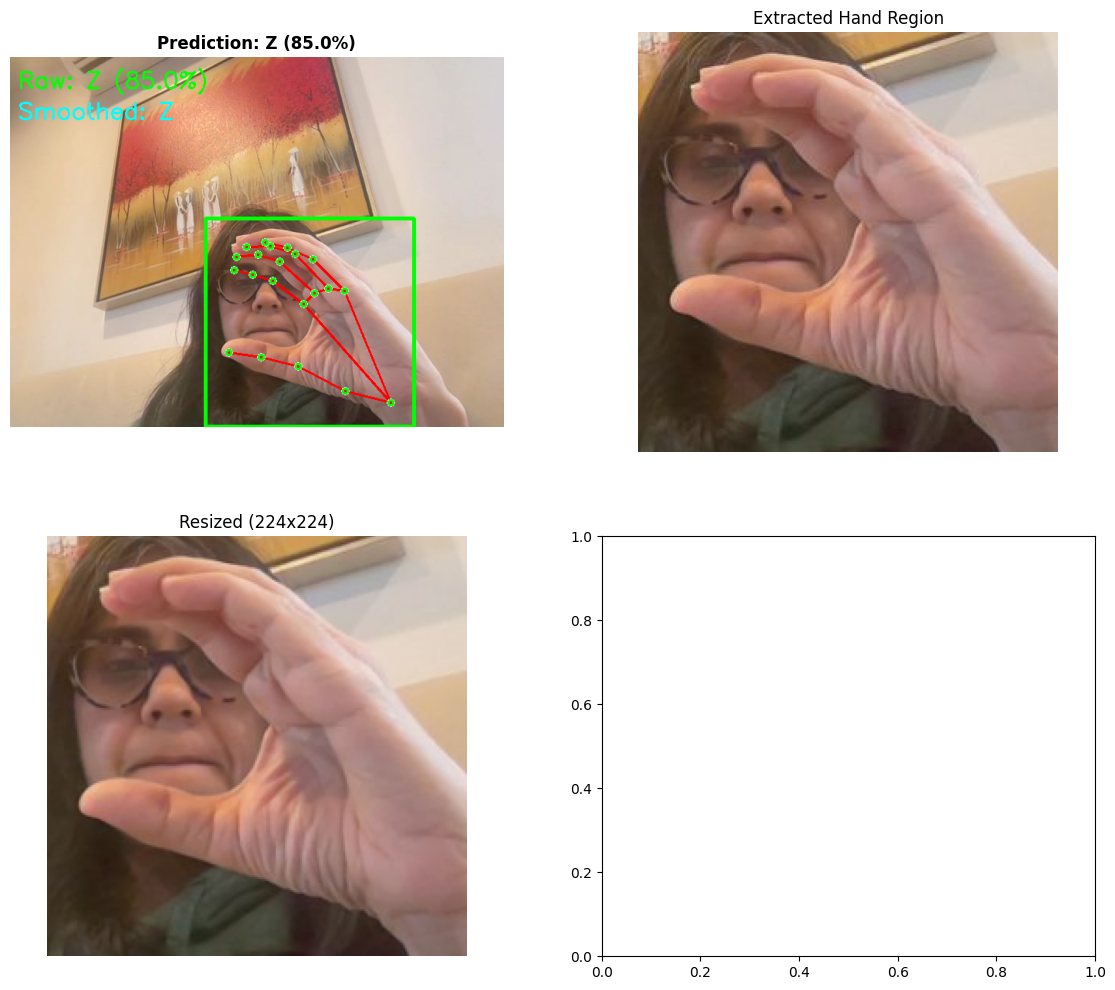

In [64]:
# Reset smoother first
smoother.reset()

# Try improved version
webcam_inference_v2()

In [65]:
# ============================================================
# SOLUTION: HAND SEGMENTATION TO REMOVE BACKGROUND
# ============================================================

def segment_hand(img_bgr, hand_landmarks):
    """
    Create a mask of just the hand, remove background
    """
    h, w = img_bgr.shape[:2]

    # Create blank mask
    mask = np.zeros((h, w), dtype=np.uint8)

    # Get hand landmarks as polygon
    points = []
    for landmark in hand_landmarks.landmark:
        x = int(landmark.x * w)
        y = int(landmark.y * h)
        points.append([x, y])

    # Create convex hull around hand
    points = np.array(points)
    hull = cv2.convexHull(points)

    # Fill the hull to create mask
    cv2.fillConvexPoly(mask, hull, 255)

    # Dilate mask slightly to include edges
    kernel = np.ones((15, 15), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Apply mask to image
    hand_only = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

    # Replace background with white (like training data)
    background = np.ones_like(img_bgr) * 255
    mask_inv = cv2.bitwise_not(mask)
    background = cv2.bitwise_and(background, background, mask=mask_inv)
    hand_with_white_bg = cv2.add(hand_only, background)

    return hand_with_white_bg, mask

def webcam_with_segmentation():
    """
    Webcam inference with hand segmentation
    """
    print("="*60)
    print("WEBCAM WITH HAND SEGMENTATION (Background Removal)")
    print("="*60)

    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';

            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            await new Promise((resolve) => setTimeout(resolve, 2000));

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            const img = canvas.toDataURL('image/jpeg', 0.8);

            stream.getVideoTracks()[0].stop();
            div.remove();

            return img;
        }
    ''')

    display(js)
    data = eval_js('takePhoto()')

    binary = b64decode(data.split(',')[1])
    img = Image.open(BytesIO(binary))
    img_array = np.array(img)
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Segment hand (remove background)
            hand_segmented, mask = segment_hand(img_bgr, hand_landmarks)

            # Get bounding box
            h, w = img_bgr.shape[:2]
            x_min, y_min, x_max, y_max = get_hand_bbox_tight(hand_landmarks, w, h, padding=30)

            # Extract segmented hand region
            hand_region = hand_segmented[y_min:y_max, x_min:x_max]

            if hand_region.size > 0:
                # Preprocess
                processed = preprocess_hand_region(hand_region)

                # Predict
                prediction = model.predict(processed, verbose=0)
                predicted_idx = np.argmax(prediction)
                confidence = np.max(prediction)
                predicted_class = classes[predicted_idx]

                # Visualize
                fig, axes = plt.subplots(2, 3, figsize=(15, 10))

                # Original
                axes[0, 0].imshow(img_rgb)
                axes[0, 0].set_title("Original", fontsize=12)
                axes[0, 0].axis('off')

                # Mask
                axes[0, 1].imshow(mask, cmap='gray')
                axes[0, 1].set_title("Hand Mask", fontsize=12)
                axes[0, 1].axis('off')

                # Segmented
                axes[0, 2].imshow(cv2.cvtColor(hand_segmented, cv2.COLOR_BGR2RGB))
                axes[0, 2].set_title("Segmented (White BG)", fontsize=12)
                axes[0, 2].axis('off')

                # Cropped region
                axes[1, 0].imshow(cv2.cvtColor(hand_region, cv2.COLOR_BGR2RGB))
                axes[1, 0].set_title("Extracted Region", fontsize=12)
                axes[1, 0].axis('off')

                # Resized
                hand_resized = cv2.resize(hand_region, (224, 224))
                axes[1, 1].imshow(cv2.cvtColor(hand_resized, cv2.COLOR_BGR2RGB))
                axes[1, 1].set_title(f"Model Input\nPrediction: {predicted_class} ({confidence:.1%})",
                                     fontsize=12, fontweight='bold')
                axes[1, 1].axis('off')

                # Training sample comparison
                sample_dir = os.path.join(actual_class_dir, predicted_class)
                sample_img_path = os.path.join(sample_dir, os.listdir(sample_dir)[0])
                sample_img = plt.imread(sample_img_path)
                axes[1, 2].imshow(sample_img)
                axes[1, 2].set_title(f"Training: {predicted_class}", fontsize=12)
                axes[1, 2].axis('off')

                plt.tight_layout()
                plt.show()

                print(f"\n{'='*60}")
                print(f"PREDICTION: {predicted_class}")
                print(f"CONFIDENCE: {confidence:.2%}")
                print(f"{'='*60}")

                # Top 5
                top_5_idx = np.argsort(prediction[0])[-5:][::-1]
                print("\nTop 5 predictions:")
                for rank, idx in enumerate(top_5_idx, 1):
                    bar = "█" * int(prediction[0][idx] * 50)
                    print(f"  {rank}. {classes[idx]:8s} {prediction[0][idx]:6.2%} {bar}")
    else:
        print("✗ No hand detected")
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

print("✓ Hand segmentation function ready")
print("\nRun: webcam_with_segmentation()")

✓ Hand segmentation function ready

Run: webcam_with_segmentation()


WEBCAM WITH HAND SEGMENTATION (Background Removal)


<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: '/content/asl_data/asl_alphabet_train/asl_alphabet_train/W'

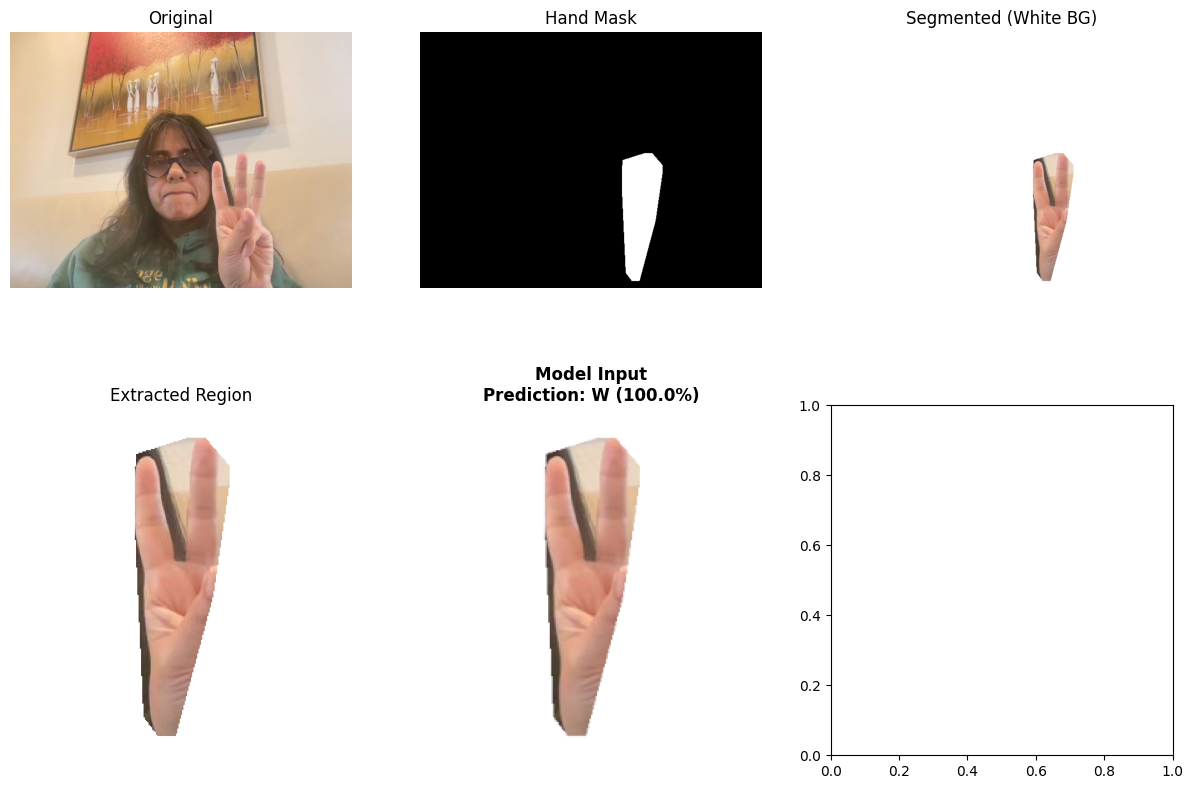

In [86]:
webcam_with_segmentation()